In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score , mean_squared_log_error 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
import joblib  
from keras.layers import Activation

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np
from keras.utils.vis_utils import plot_model



In [2]:
movielens_dir = "../ml-25m/"
ratings_file = movielens_dir + "ratings.csv"
df = pd.read_csv(ratings_file )
df_newMovies = pd.read_csv(movielens_dir+ "newMovies.csv",index_col="movieId")
df_providers = pd.read_csv(movielens_dir+ "providers.csv")
df_providers.provider_id = df_providers.provider_id.apply(str)


## cargando las peliculas

#### se convierte a dummies los generos de las peliculas

In [3]:
df_model_movies = df_newMovies[ "year"].copy() 
df_genres = df_newMovies['genres'].str.get_dummies(sep='|')
df_genres = df_genres[['Acción', 'Animación', 'Aventura', 'Bélica','Ciencia ficción', 'Comedia', 'Crimen', 'Documental', 'Drama','Familia', 'Fantasía', 'Historia', 'Misterio', 'Música', 'Película de TV', 'Romance', 'Suspense', 'Terror', 'Western']]
df_model_movies = pd.merge(left=df_model_movies,right=df_genres, left_on='movieId', right_on='movieId')
df_model_movies

,year,Acción,Animación,Aventura,Bélica,Ciencia ficción,Comedia,Crimen,Documental,Drama,Familia,Fantasía,Historia,Misterio,Música,Película de TV,Romance,Suspense,Terror,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,1995.0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1995.0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,1995.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1995.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
5,1995.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,2018.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
209159,2001.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209163,2018.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


#### se consultas los proveedores y se convierte en dummies

In [4]:
df_model_provider = df_providers.groupby(["movieId"]).agg({'provider_id': "|".join})
df_model_provider = df_model_provider['provider_id'].str.get_dummies(sep='|')
df_model_movies = pd.merge(left=df_model_movies,right=df_model_provider, left_on='movieId', right_on='movieId')
df_model_movies

,year,Acción,Animación,Aventura,Bélica,Ciencia ficción,Comedia,Crimen,Documental,Drama,...,534,546,551,554,567,569,575,619,67,8
movieId,,,,,,,,,,,,,,,,,,,,,
1,1995.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1995.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1995.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208915,2019.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208939,2019.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
208943,2019.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Se hace el group by y se saca la media de calificación

In [5]:
df_movie_mean = df.groupby(["movieId"]).mean()
df_movie_mean

,userId,rating,timestamp
movieId,,,
1,81294.564728,3.893708,1.153152e+09
2,81358.542554,3.251527,1.122310e+09
3,81343.694934,3.142028,9.806023e+08
4,81266.193024,2.853547,9.424605e+08
5,81002.872460,3.058434,1.004723e+09
...,...,...,...
209157,119571.000000,1.500000,1.574281e+09
209159,115835.000000,3.000000,1.574281e+09
209163,6964.000000,4.500000,1.574285e+09


### se realiza el join

In [6]:
df_model_movies = pd.merge(left=df_model_movies,right=df_movie_mean["rating"], left_on='movieId', right_on='movieId')
df_model_movies

,year,Acción,Animación,Aventura,Bélica,Ciencia ficción,Comedia,Crimen,Documental,Drama,...,546,551,554,567,569,575,619,67,8,rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1995.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.893708
2,1995.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.251527
3,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.142028
4,1995.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,2.853547
5,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.058434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208915,2019.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.500000
208939,2019.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,4.312500
208943,2019.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.000000


In [7]:
df_model_movies

,year,Acción,Animación,Aventura,Bélica,Ciencia ficción,Comedia,Crimen,Documental,Drama,...,546,551,554,567,569,575,619,67,8,rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1995.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.893708
2,1995.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.251527
3,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.142028
4,1995.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,2.853547
5,1995.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.058434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208915,2019.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.500000
208939,2019.0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,4.312500
208943,2019.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.000000


### Separar en Train y Test

In [8]:
X = df_model_movies[[ 'Acción', 'Animación', 'Aventura', 'Bélica', 'Ciencia ficción',
       'Comedia', 'Crimen', 'Documental', 'Drama', 'Familia', 'Fantasía',
       'Historia', 'Misterio', 'Música', 'Película de TV', 'Romance',
       'Suspense', 'Terror', 'Western', '11', '119', '167', '190', '2', '3',
       '31', '315', '337', '339', '350', '384', '444', '445', '467', '475',
       '521', '531', '534', '546', '551', '554', '567', '569', '575', '619',
       '67', '8']].values
y = df_model_movies[['rating']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
y_train

array([[3.9110056 ],
       [1.99206349],
       [3.83333333],
       ...,
       [3.79411765],
       [3.35714286],
       [3.02941176]])

In [9]:
X_train.shape
## number of inputs 

(8426, 47)

### crear el modelo ANN

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu',
			input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

plot_model(model, to_file='ANN_Content_base.png', show_shapes=True, show_layer_names=False)


model.compile( loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.05) )
epochs_hist = model.fit(X_train, y_train, epochs=50, validation_data =(X_test, y_test),
	verbose=1)

Epoch 1/50
264/264 [==============================] - 1s 3ms/step - loss: 1.0404 - mae: 0.6301 - val_loss: 0.3519 - val_mae: 0.4559
Epoch 2/50
264/264 [==============================] - 1s 3ms/step - loss: 0.3580 - mae: 0.4491 - val_loss: 0.3382 - val_mae: 0.4344
Epoch 3/50
264/264 [==============================] - 1s 2ms/step - loss: 0.3538 - mae: 0.4479 - val_loss: 0.3296 - val_mae: 0.4275
Epoch 4/50
264/264 [==============================] - 0s 2ms/step - loss: 0.3482 - mae: 0.4440 - val_loss: 0.3279 - val_mae: 0.4311
Epoch 5/50
264/264 [==============================] - 0s 2ms/step - loss: 0.3515 - mae: 0.4480 - val_loss: 0.3375 - val_mae: 0.4265
Epoch 6/50
264/264 [==============================] - 0s 2ms/step - loss: 0.3483 - mae: 0.4434 - val_loss: 0.3341 - val_mae: 0.4314
Epoch 7/50
264/264 [==============================] - 0s 2ms/step - loss: 0.3518 - mae: 0.4470 - val_loss: 0.3486 - val_mae: 0.4565
Epoch 8/50
264/264 [==============================] - 1s 2ms/step - loss: 0.

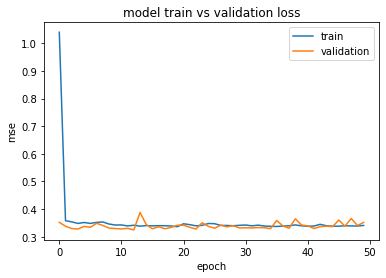

In [35]:
loss = np.array(epochs_hist.history['loss'])
val_loss = np.array(epochs_hist.history['val_loss'])

plt.plot(loss)
plt.plot(val_loss)
plt.title('model train vs validation loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [36]:
y_predic = model.predict(X_test)
y_predic_ANN = y_predic

In [37]:
for n in y_predic:
    if n > 4: 
        print(n)

[4.4000998]
[4.4000998]


In [38]:
print("MSE {} %".format(mean_squared_error(y_test,y_predic_ANN)))
print("MAE {} %".format(mean_absolute_error(y_test,y_predic_ANN)))
print("R2 {} %".format(r2_score(y_test,y_predic_ANN)))
print("MSLE {} %".format(mean_squared_log_error(y_test,y_predic_ANN)))

MSE 0.3515529960104302 %
MAE 0.45659340164980505 %
R2 0.05175496024153503 %
MSLE 0.025289984044434808 %


Text(0, 0.5, 'Density')

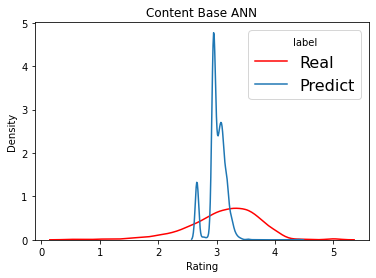

In [39]:
# Draw the density plot
sns.kdeplot(data = y_test.squeeze(), 
                label = "Real",
                color = "red")

# Draw the density plot
sns.kdeplot(data = y_predic_ANN.squeeze(), 
                label = "Predict")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'label')
plt.title('Content Base ANN')
plt.xlabel('Rating')
plt.ylabel('Density')

### SVM

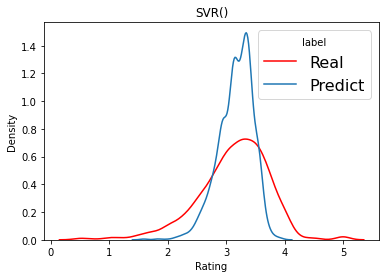

SVR()
MSE 0.31491194053831495 %
MAE 0.41256628093141584 %
R2 0.15058699836166312 %
MSLE 0.023465669040548077 %


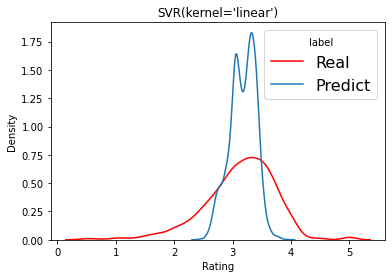

SVR(kernel='linear')
MSE 0.3255427448636514 %
MAE 0.4191488879417641 %
R2 0.12191249527239334 %
MSLE 0.02455572383527264 %


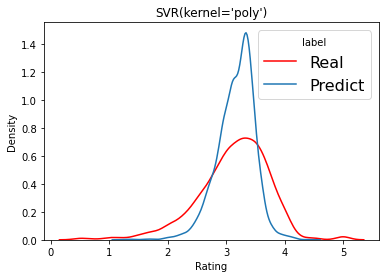

SVR(kernel='poly')
MSE 0.3280917396808053 %
MAE 0.42360118996329227 %
R2 0.11503708326007611 %
MSLE 0.02434414960805661 %


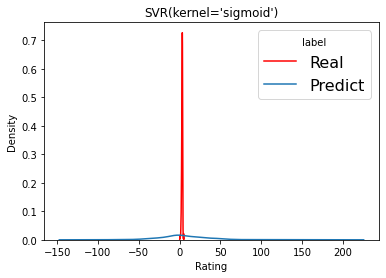

SVR(kernel='sigmoid')
MSE 1202.0136059725307 %
MAE 24.716919919548157 %
R2 -3241.1952096002656 %


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [40]:
models = [] 
models.append(svm.SVR(kernel = 'rbf'))
models.append(svm.SVR(kernel = 'linear'))
models.append(svm.SVR(kernel = 'poly'))
models.append(svm.SVR(kernel = 'sigmoid'))

for model in models:
    model.fit( X_train, y_train )
    y_pred_svm_lineal = model.predict(X_test)

    # Draw the density plot
    sns.kdeplot(data = y_test.squeeze(), 
                    label = "Real",
                    color = "red")

    # Draw the density plot
    sns.kdeplot(data = y_pred_svm_lineal.squeeze(), 
                    label = "Predict")

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'label')
    plt.title(model)
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.show()

    print(model)
    print("MSE {} %".format(mean_squared_error(y_test,y_pred_svm_lineal)))
    print("MAE {} %".format(mean_absolute_error(y_test,y_pred_svm_lineal)))
    print("R2 {} %".format(r2_score(y_test,y_pred_svm_lineal)))
    print("MSLE {} %".format(mean_squared_log_error(y_test,y_pred_svm_lineal)))



Text(0, 0.5, 'Density')

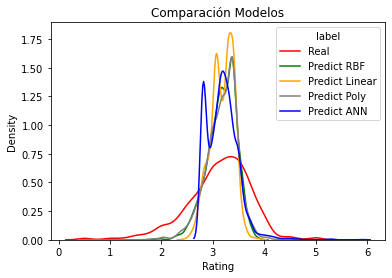

In [ ]:


y_pred_svm_rbf = svm.SVR(kernel = 'rbf').fit( X_train, y_train ).predict(X_test)
y_pred_svm_linear = svm.SVR(kernel = 'linear').fit( X_train, y_train ).predict(X_test)
y_pred_svm_poly = svm.SVR(kernel = 'poly').fit( X_train, y_train ).predict(X_test)

# Draw the density plot
sns.kdeplot(data = y_test.squeeze(), 
                label = "Real",
                color = "red")

# Draw the density plot
sns.kdeplot(data = y_pred_svm_rbf.squeeze(), label = "Predict RBF", color = "green")
sns.kdeplot(data = y_pred_svm_linear.squeeze(), label = "Predict Linear", color = "orange")
sns.kdeplot(data = y_pred_svm_poly.squeeze(), label = "Predict Poly", color = "gray")
sns.kdeplot(data = y_predic_ANN.squeeze(), label = "Predict ANN", color = "blue")


# Plot formatting
plt.legend(prop={'size': 10}, title = 'label')
plt.title("Comparación Modelos")
plt.xlabel('Rating')
plt.ylabel('Density')



## Validación cruzada para encontrar el mejor algoritmo

In [ ]:
def get_model_RN():
    model = Sequential()
    model.add(Dense(128, activation='relu',
            input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile( loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.05) )
    return model
   

def get_models():
    models = dict()
    models['RN'] = KerasClassifier(build_fn=get_model_RN,epochs=50, verbose=0)
    models['SVM_LIN'] = svm.SVR(kernel = 'linear')
    models['SVM_RBF'] = svm.SVR(kernel = 'rbf')
    models['SVM_POL'] = svm.SVR(kernel = 'poly')
    models['SVM_SIG'] = svm.SVR(kernel = 'sigmoid')

    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=25)
	scores = cross_val_score( model, X, y, cv=cv, scoring='neg_mean_squared_error')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>RN -6.434 (0.465)
>SVM_LIN -0.341 (0.192)
>SVM_RBF -0.334 (0.189)
>SVM_POL -0.348 (0.185)
>SVM_SIG -2225.424 (264.852)


### Se quitó RN y SIgmoidal ya que tienen malores muy altos y afecta en la gráfica

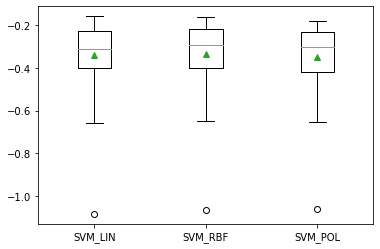

In [ ]:
# plot model performance for comparison
plt.boxplot(results[1:-1], labels=names[1:-1], showmeans=True)
plt.show()

### después de decidir que se va a usar SVM RBF se realiza la cross validation para encontrar el C

In [ ]:
def get_models_SVM():
    models = dict()
    models['SVM_RBF_C0001'] = svm.SVR( C=0.001 ,  kernel = 'rbf')
    models['SVM_RBF_C005'] = svm.SVR( C=0.05 ,  kernel = 'rbf')
    models['SVM_RBF_C01'] = svm.SVR( C=0.1 , kernel = 'rbf')
    models['SVM_RBF_C05'] = svm.SVR( C=0.5 , kernel = 'rbf')
    models['SVM_RBF_C1'] = svm.SVR( C=1 , kernel = 'rbf')
    models['SVM_RBF_C5'] = svm.SVR( C=5 , kernel = 'rbf')
    models['SVM_RBF_C10'] = svm.SVR( C=10 , kernel = 'rbf')

    return models

# evaluate a give model using cross-validation
def evaluate_model_SVM(model, X, y):
	cv = KFold(n_splits=25)
	scores = cross_val_score( model, X, y, cv=cv, scoring='neg_mean_squared_error')
	return scores

# get the models to evaluate
models = get_models_SVM()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))



>SVM_LIN_C0001 -0.366 (0.195)
>SVM_LIN_C005 -0.332 (0.192)
>SVM_LIN_C01 -0.330 (0.192)
>SVM_LIN_C05 -0.331 (0.190)
>SVM_LIN_C1 -0.334 (0.189)
>SVM_LIN_C5 -0.358 (0.187)
>SVM_LIN_C10 -0.376 (0.187)


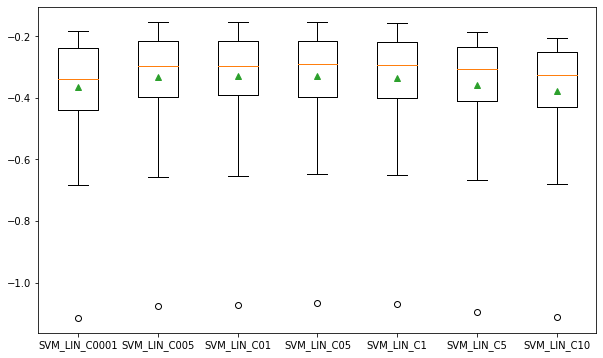

In [ ]:
plt.figure(figsize=(10, 6))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Modelo Seleccionado

In [ ]:
model = svm.SVR(kernel = 'rbf')
model.fit( X_train, y_train )
y_pred_svm_lineal = model.predict(X_test)
print("MSE {} %".format(mean_squared_error(y_test,y_pred_svm_lineal)))

MSE 34.36919865706983 %


In [ ]:
joblib.dump(model, 'modelo_SVM_movies.pkl') # Guardo el modelo.

['modelo_SVM_movies.pkl']

In [ ]:
modelo_cargado = joblib.load('modelo_SVM_movies.pkl') # Carga del modelo.
y_pred_svm_lineal = modelo_cargado.predict(X_test)

In [ ]:
print("MSE {} %".format(mean_squared_error(y_test,y_pred_svm_lineal)))

MSE 34.36919865706983 %
